In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Impute Missing Values in CSV and reading CSV file

In [74]:
# Reading CSV file
diab = pd.read_csv('diabetes.csv')

# Impute missing values
def impute_missing_values(df):
    columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
               'DiabetesPedigreeFunction', 'Age']

    df[columns] = df[columns].replace(0, np.nan)
    df[columns] = df[columns].apply(lambda col: col.fillna(col.median()))

    return df

# Storing DF to a variable
diab = impute_missing_values(diab)

# Feature and label separation
features = diab.iloc[:, :-1]
labels = diab.iloc[:, -1]

print('Displaying Total Positive and Total Negative\n')
print('Number of Positive Outcomes: ', labels.value_counts()[0])
print('Number of Negative Outcomes : ', labels.value_counts()[1])
print('\n')

Displaying Total Positive and Total Negative

Number of Positive Outcomes:  500
Number of Negative Outcomes :  268




## Correlation Analysis of Attributes

In [75]:
# Evaluating Correlations between Features
correlation_matrix = features.corr()
correlation_pairs = correlation_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
correlation_pairs = correlation_pairs[correlation_pairs < 1.0]
highest_corr_pairs = correlation_pairs.head(4)

print('Pairs that are heighest correlated: \n')
print(highest_corr_pairs.round(decimals=2).T)
print('\n')

Pairs that are heighest correlated: 

SkinThickness  BMI              0.54
BMI            SkinThickness    0.54
Pregnancies    Age              0.52
Age            Pregnancies      0.52
dtype: float64




## Splitting Data for Training and Test dataset

In [76]:
# Method to split the data into training and test data set.
def split_data(features, labels, test_size=0.1, random_state=21, stratify=None):
    return train_test_split(features, labels, test_size=test_size, random_state=random_state, 
                            stratify=stratify)

features_train_all, features_test_all, labels_train_all, labels_test_all = split_data(features, labels, 
                                                                                      stratify=labels)

# Method to reset the each dataset
def reset_index(datasets):
    for dataset in datasets:
        dataset.reset_index(drop=True, inplace=True)

reset_index([features_train_all, features_test_all, labels_train_all, labels_test_all])

# This standardization ensures that the scale of the features are balanced for the model's performance
# Standardize features for training set
features_train_all_std = (features_train_all - features_train_all.mean()) / features_train_all.std()

# Standardize features for testing set
features_test_all_std = (features_test_all - features_test_all.mean()) / features_test_all.std()

## Metric Calculation
- Calculating TP, FN, FP, TN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS

In [77]:
def calculate_metrics(conf_matrix):
    TP, FN = conf_matrix[0][0], conf_matrix[0][1]
    FP, TN = conf_matrix[1][0], conf_matrix[1][1]
    
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    Precision = TP / (TP + FP)
    F1_measure = 2 * TP / (2 * TP + FP + FN)
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    # Balanced Accuracy
    BACC = (TPR + TNR) / 2
    # True Skill Statistics
    TSS = TPR - FPR
    # Heidke Skill Score
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    
    return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS]

## Evaluating Performance of Machine Learning Model
- Trains different models using the training data and evaluates it using the test data
- If the model is LSTM:
  - function will reshape the input data and calculates metrics that is specific to LSTM
- Returns a list of metrics that includes:
  - confusion matrix-derived metrics
  - Brier score

In [78]:
def get_metrics(model, x_train, x_test, y_train, y_test, LSTM_flag):
    metrics = []

    # Convert data to numpy array
    feature_train, feature_test, label_train, label_test = map(np.array, [x_train, x_test, y_train, y_test])

    # if LSTM flag is true
    if LSTM_flag:
        # Reshape data for LSTM model
        x_train_reshaped = feature_train.reshape(len(feature_train), feature_train.shape[1], 1)
        x_test_reshaped = feature_test.reshape(len(feature_test), feature_test.shape[1], 1)
        
        model.fit(x_train_reshaped, label_train, epochs=50, validation_data=(x_test_reshaped, 
                                                                             label_test), verbose=0)
        lstm_scores = model.evaluate(x_test_reshaped, label_test, verbose=0)
        predict_prob = model.predict(x_test_reshaped)
        pred_labels = (predict_prob > 0.5).astype(int)
        conf_matrix = confusion_matrix(label_test, pred_labels, labels=[1, 0])
        lstm_brier_score = brier_score_loss(label_test, predict_prob)
        metrics.extend(calculate_metrics(conf_matrix))
        metrics.extend([lstm_brier_score, lstm_scores[1]])

    # if LSTM flag is false
    else:
        model.fit(feature_train, label_train)
        conf_matrix = confusion_matrix(label_test, model.predict(feature_test), labels=[1, 0])
        model_brier_score = brier_score_loss(label_test, model.predict_proba(feature_test)[:, 1])
        metrics.extend(calculate_metrics(conf_matrix))
        metrics.extend([model_brier_score, model.score(feature_test, label_test)])
        
    return metrics

## Classification Algorithm Choice

- Classification algorithms
  - KNN
  - Random Forest
- Deep Learning algorithm
  - LSTM (Long Short Term Memory)

In [79]:
# KNN
# KNN parameters for grid search
knn_parameters = {"n_neighbors": range(1, 16)}

knn_model = KNeighborsClassifier()

# Grid search with cross-validation
knn_cv = GridSearchCV(knn_model, knn_parameters, cv=10, n_jobs=-1)
knn_cv.fit(features_train_all_std, labels_train_all)
neighbors = knn_cv.best_params_['n_neighbors']

print('KNN Parameter: ', neighbors)
print('\n')

KNN Parameter:  15




In [80]:
# RF (Random Forest)
# RF parameters for grid search
param_grid_rf = {"n_estimators": range(10, 110, 10), "min_samples_split": range(2, 12, 2)}
rf_model = RandomForestClassifier()

# Grid search with cross-validation
rf_cv = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=10, n_jobs=-1)
rf_cv.fit(features_train_all_std, labels_train_all)

# Values for 'min_samples_split' and 'n_estimators'
split = rf_cv.best_params_['min_samples_split']
estimators = rf_cv.best_params_['n_estimators']
print('Random Forest Parameter: ', rf_cv.best_params_)
print('\n')

Random Forest Parameter:  {'min_samples_split': 6, 'n_estimators': 50}




In [81]:
# LSTM (Long Short Term Memory)
def get_LSTM():
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, activation='relu', batch_input_shape=(None, 8 ,1), return_sequences=False))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return lstm_model

## Implementing 10-Fold Stratified Cross-Validation

In [82]:
kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

# Metric columns
metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'F1_measure', 'Accuracy', 
                 'Error_rate', 'BACC', 'TSS', 'HSS', 'Brier_score', 'Acc_by_package_fn']

# List for each algorithm
knn_metrics_list, rf_metrics_list, lstm_metrics_list = [], [], []

# for loop for 10-fold iterations
for iter_num, (train_index, test_index) in enumerate(kFold.split(features_train_all_std, 
                                                                 labels_train_all), start=1):
    # KNN model
    knn_model = KNeighborsClassifier(n_neighbors=neighbors)
    # RF model
    rf_model = RandomForestClassifier(min_samples_split=split, n_estimators=estimators)
    # LSTM model
    lstm_model = get_LSTM()

    # Spliting data into training and testing data sets
    features_train, features_test = features_train_all_std.iloc[train_index, :], features_train_all_std.iloc[test_index, :]
    labels_train, labels_test = labels_train_all[train_index], labels_train_all[test_index]
    
    knn_metrics = get_metrics(knn_model, features_train, features_test, labels_train, labels_test, 0)
    rf_metrics = get_metrics(rf_model, features_train, features_test, labels_train, labels_test, 0)
    lstm_metrics = get_metrics(lstm_model, features_train, features_test, labels_train, labels_test, 1)
    
    knn_metrics_list.append(knn_metrics)
    rf_metrics_list.append(rf_metrics)
    lstm_metrics_list.append(lstm_metrics)
    
    metrics_all_df = pd.DataFrame([knn_metrics, rf_metrics, lstm_metrics], columns=metric_columns, 
                                  index=['KNN', 'RF', 'LSTM'])
    print('\nMetrics for all Algoritm in Iteration {}\n'.format(iter_num))
    display(metrics_all_df.round(decimals=2).T)
    print('\n')

3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 1



,KNN,RF,LSTM
TP,14.00,17.00,13.00
TN,39.00,37.00,37.00
FP,6.00,8.00,8.00
FN,11.00,8.00,12.00
TPR,0.56,0.68,0.52
TNR,0.87,0.82,0.82
FPR,0.13,0.18,0.18
FNR,0.44,0.32,0.48
Precision,0.70,0.68,0.62
F1_measure,0.62,0.68,0.57




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 2



,KNN,RF,LSTM
TP,12.00,11.00,13.00
TN,38.00,39.00,32.00
FP,7.00,6.00,13.00
FN,12.00,13.00,11.00
TPR,0.50,0.46,0.54
TNR,0.84,0.87,0.71
FPR,0.16,0.13,0.29
FNR,0.50,0.54,0.46
Precision,0.63,0.65,0.50
F1_measure,0.56,0.54,0.52




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 3



,KNN,RF,LSTM
TP,11.00,12.00,9.00
TN,34.00,34.00,38.00
FP,11.00,11.00,7.00
FN,13.00,12.00,15.00
TPR,0.46,0.50,0.38
TNR,0.76,0.76,0.84
FPR,0.24,0.24,0.16
FNR,0.54,0.50,0.62
Precision,0.50,0.52,0.56
F1_measure,0.48,0.51,0.45




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 4



,KNN,RF,LSTM
TP,13.00,18.00,11.00
TN,41.00,41.00,43.00
FP,4.00,4.00,2.00
FN,11.00,6.00,13.00
TPR,0.54,0.75,0.46
TNR,0.91,0.91,0.96
FPR,0.09,0.09,0.04
FNR,0.46,0.25,0.54
Precision,0.76,0.82,0.85
F1_measure,0.63,0.78,0.59




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 5



,KNN,RF,LSTM
TP,7.00,10.00,12.00
TN,41.00,38.00,39.00
FP,4.00,7.00,6.00
FN,17.00,14.00,12.00
TPR,0.29,0.42,0.50
TNR,0.91,0.84,0.87
FPR,0.09,0.16,0.13
FNR,0.71,0.58,0.50
Precision,0.64,0.59,0.67
F1_measure,0.40,0.49,0.57




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 6



,KNN,RF,LSTM
TP,16.00,17.00,17.00
TN,40.00,40.00,35.00
FP,5.00,5.00,10.00
FN,8.00,7.00,7.00
TPR,0.67,0.71,0.71
TNR,0.89,0.89,0.78
FPR,0.11,0.11,0.22
FNR,0.33,0.29,0.29
Precision,0.76,0.77,0.63
F1_measure,0.71,0.74,0.67




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 7



,KNN,RF,LSTM
TP,16.00,16.00,15.00
TN,38.00,35.00,34.00
FP,7.00,10.00,11.00
FN,8.00,8.00,9.00
TPR,0.67,0.67,0.62
TNR,0.84,0.78,0.76
FPR,0.16,0.22,0.24
FNR,0.33,0.33,0.38
Precision,0.70,0.62,0.58
F1_measure,0.68,0.64,0.60




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 8



,KNN,RF,LSTM
TP,14.00,13.00,13.00
TN,40.00,39.00,40.00
FP,5.00,6.00,5.00
FN,10.00,11.00,11.00
TPR,0.58,0.54,0.54
TNR,0.89,0.87,0.89
FPR,0.11,0.13,0.11
FNR,0.42,0.46,0.46
Precision,0.74,0.68,0.72
F1_measure,0.65,0.60,0.62




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 9



,KNN,RF,LSTM
TP,15.00,17.00,17.00
TN,40.00,34.00,37.00
FP,5.00,11.00,8.00
FN,9.00,7.00,7.00
TPR,0.62,0.71,0.71
TNR,0.89,0.76,0.82
FPR,0.11,0.24,0.18
FNR,0.38,0.29,0.29
Precision,0.75,0.61,0.68
F1_measure,0.68,0.65,0.69




3/3 [==============================] - 0s 1ms/step

Metrics for all Algoritm in Iteration 10



,KNN,RF,LSTM
TP,16.00,18.00,15.00
TN,38.00,41.00,39.00
FP,7.00,4.00,6.00
FN,8.00,6.00,9.00
TPR,0.67,0.75,0.62
TNR,0.84,0.91,0.87
FPR,0.16,0.09,0.13
FNR,0.33,0.25,0.38
Precision,0.70,0.82,0.71
F1_measure,0.68,0.78,0.67


## Metric for each Iteration and Algorithm

In [83]:
# Define iteration indices
metric_index_df = [f'iter{i}' for i in range(1, 11)]

# Create DataFrames for each algorithm's metrics
metrics_dfs = {
    'KNN': pd.DataFrame(knn_metrics_list, columns=metric_columns, index=metric_index_df),
    'RF': pd.DataFrame(rf_metrics_list, columns=metric_columns, index=metric_index_df),
    'LSTM': pd.DataFrame(lstm_metrics_list, columns=metric_columns, index=metric_index_df)
}

# Print metrics for each algorithm
for algo_name, metrics_df in metrics_dfs.items():
    print(f"\nMetrics for Algorithm {algo_name}:\n")
    display(metrics_df.round(decimals=2).T)


Metrics for Algorithm KNN:



,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10
TP,14.00,12.00,11.00,13.00,7.00,16.00,16.00,14.00,15.00,16.00
TN,39.00,38.00,34.00,41.00,41.00,40.00,38.00,40.00,40.00,38.00
FP,6.00,7.00,11.00,4.00,4.00,5.00,7.00,5.00,5.00,7.00
FN,11.00,12.00,13.00,11.00,17.00,8.00,8.00,10.00,9.00,8.00
TPR,0.56,0.50,0.46,0.54,0.29,0.67,0.67,0.58,0.62,0.67
TNR,0.87,0.84,0.76,0.91,0.91,0.89,0.84,0.89,0.89,0.84
FPR,0.13,0.16,0.24,0.09,0.09,0.11,0.16,0.11,0.11,0.16
FNR,0.44,0.50,0.54,0.46,0.71,0.33,0.33,0.42,0.38,0.33
Precision,0.70,0.63,0.50,0.76,0.64,0.76,0.70,0.74,0.75,0.70
F1_measure,0.62,0.56,0.48,0.63,0.40,0.71,0.68,0.65,0.68,0.68



Metrics for Algorithm RF:



,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10
TP,17.00,11.00,12.00,18.00,10.00,17.00,16.00,13.00,17.00,18.00
TN,37.00,39.00,34.00,41.00,38.00,40.00,35.00,39.00,34.00,41.00
FP,8.00,6.00,11.00,4.00,7.00,5.00,10.00,6.00,11.00,4.00
FN,8.00,13.00,12.00,6.00,14.00,7.00,8.00,11.00,7.00,6.00
TPR,0.68,0.46,0.50,0.75,0.42,0.71,0.67,0.54,0.71,0.75
TNR,0.82,0.87,0.76,0.91,0.84,0.89,0.78,0.87,0.76,0.91
FPR,0.18,0.13,0.24,0.09,0.16,0.11,0.22,0.13,0.24,0.09
FNR,0.32,0.54,0.50,0.25,0.58,0.29,0.33,0.46,0.29,0.25
Precision,0.68,0.65,0.52,0.82,0.59,0.77,0.62,0.68,0.61,0.82
F1_measure,0.68,0.54,0.51,0.78,0.49,0.74,0.64,0.60,0.65,0.78



Metrics for Algorithm LSTM:



,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10
TP,13.00,13.00,9.00,11.00,12.00,17.00,15.00,13.00,17.00,15.00
TN,37.00,32.00,38.00,43.00,39.00,35.00,34.00,40.00,37.00,39.00
FP,8.00,13.00,7.00,2.00,6.00,10.00,11.00,5.00,8.00,6.00
FN,12.00,11.00,15.00,13.00,12.00,7.00,9.00,11.00,7.00,9.00
TPR,0.52,0.54,0.38,0.46,0.50,0.71,0.62,0.54,0.71,0.62
TNR,0.82,0.71,0.84,0.96,0.87,0.78,0.76,0.89,0.82,0.87
FPR,0.18,0.29,0.16,0.04,0.13,0.22,0.24,0.11,0.18,0.13
FNR,0.48,0.46,0.62,0.54,0.50,0.29,0.38,0.46,0.29,0.38
Precision,0.62,0.50,0.56,0.85,0.67,0.63,0.58,0.72,0.68,0.71
F1_measure,0.57,0.52,0.45,0.59,0.57,0.67,0.60,0.62,0.69,0.67


## Average Metrics for Each Algorithm

In [84]:
# Calculate the average metrics for each algorithm
avg_metrics_dfs = {
    'KNN': metrics_dfs['KNN'].mean(),
    'RF': metrics_dfs['RF'].mean(),
    'LSTM': metrics_dfs['LSTM'].mean()
}

# Create a DataFrame with the average performance for each algorithm
avg_performance_df = pd.DataFrame(avg_metrics_dfs, index=metric_columns)

# Display the average performance for each algorithm
print("Average Performance for Each Algorithm:")
display(avg_performance_df.round(decimals=2))
print('\n')

Average Performance for Each Algorithm:


,KNN,RF,LSTM
TP,13.40,14.90,13.50
TN,38.90,37.80,37.40
FP,6.10,7.20,7.60
FN,10.70,9.20,10.60
TPR,0.56,0.62,0.56
TNR,0.86,0.84,0.83
FPR,0.14,0.16,0.17
FNR,0.44,0.38,0.44
Precision,0.69,0.68,0.65
F1_measure,0.61,0.64,0.59


## Bar Plot presentation for all 3 algorithms

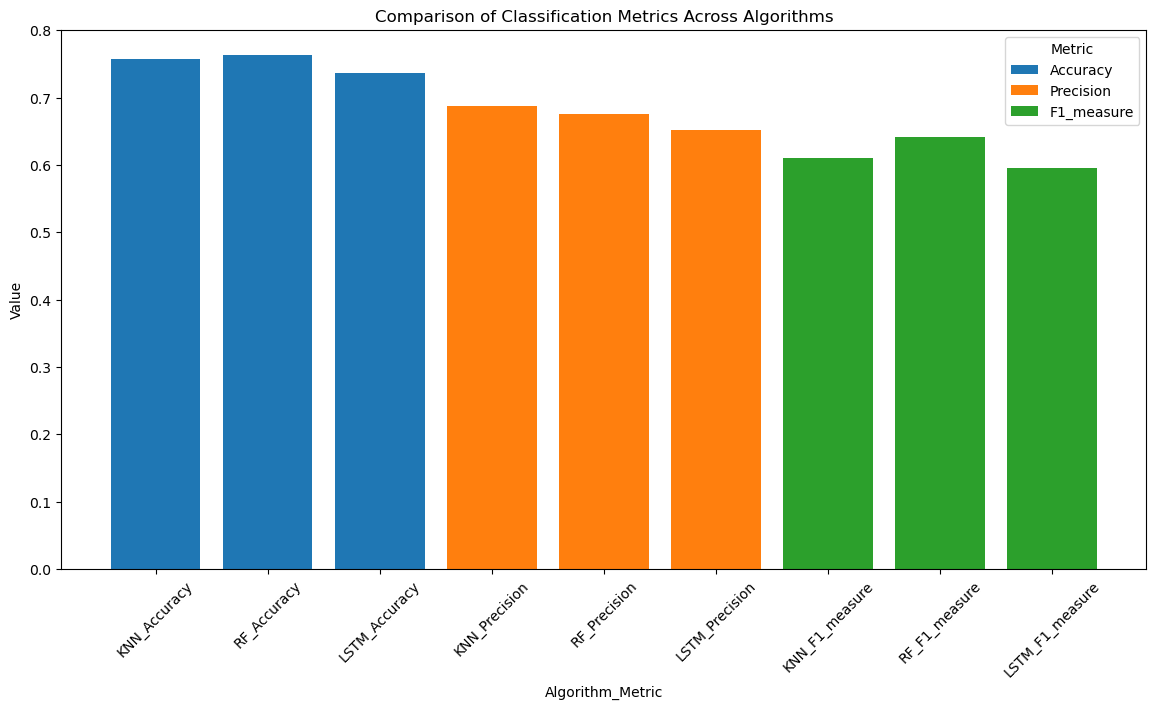

In [85]:
# Extracting data for the bar plot
metrics = ['Accuracy', 'Precision', 'F1_measure']
algorithms = ['KNN', 'RF', 'LSTM']
data = {
    'Metric': [],
    'Algorithm': [],
    'Value': []
}

for metric in metrics:
    for algo in algorithms:
        data['Metric'].append(metric)
        data['Algorithm'].append(algo)
        data['Value'].append(avg_performance_df.loc[metric, algo])

# Create a DataFrame for plotting
comparison_df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(14, 7))
for metric in metrics:
    subset = comparison_df[comparison_df['Metric'] == metric]
    plt.bar(subset['Algorithm'] + '_' + metric, subset['Value'], label=metric)

plt.xlabel('Algorithm_Metric')
plt.ylabel('Value')
plt.title('Comparison of Classification Metrics Across Algorithms')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.show()

### Conclusion

Based on the performance metrics across the algorithms, we observe that:

- **Random Forest** has the highest accuracy which makes it the most effective model for this classification problem. For improved classification performance, **Random Forest** is recommended as the preferred model.